<a href="https://colab.research.google.com/github/K-Chorna02/DST_Assessment_2/blob/main/Kateryna/KaterynaChorna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

Loading Food-101 dataset. Include some EDA in the final report.

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import random

device = "cuda" if torch.cuda.is_available() else "cpu"


# Loadijng Food-101 dataset
# Defining the original dataset
food_root = "data"
train_dataset = datasets.Food101(root=food_root, split="train", download=True)
test_dataset  = datasets.Food101(root=food_root, split="test",  download=True)

print(f"Full train size: {len(train_dataset)}, test size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")


100%|██████████| 5.00G/5.00G [03:59<00:00, 20.9MB/s]


Full train size: 75750, test size: 25250
Number of classes: 101


Showing some of the images from our dataset with differnt resolutions.

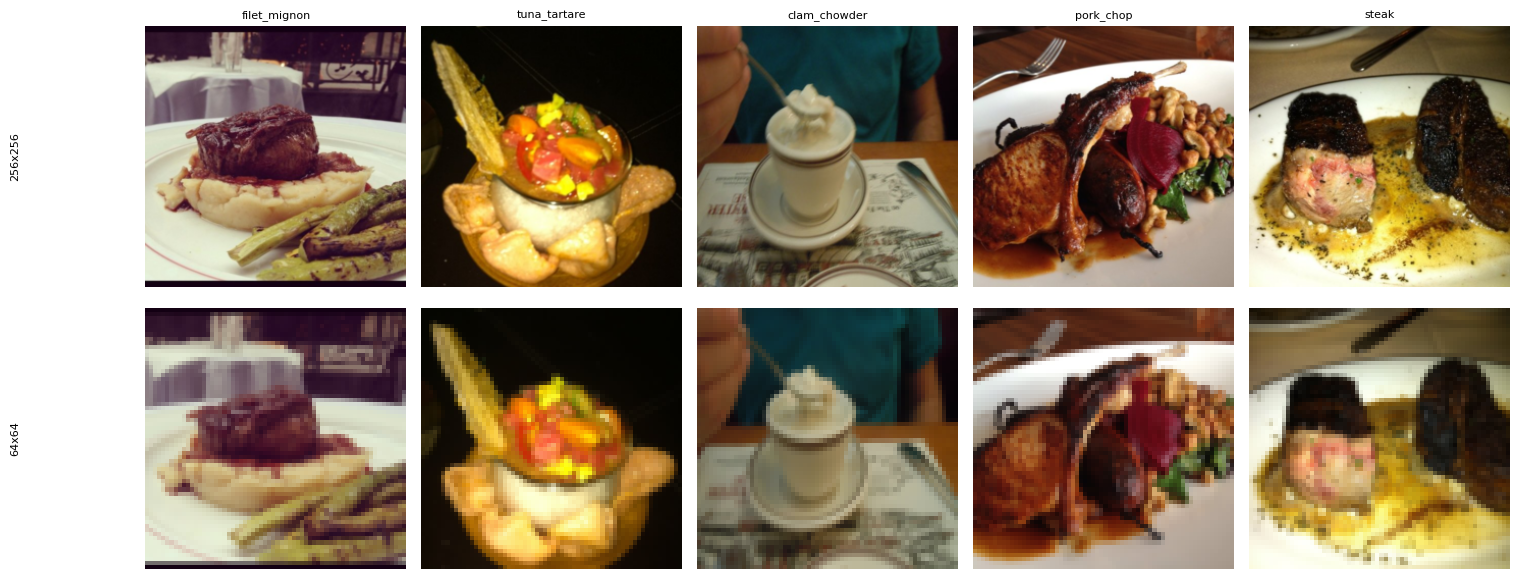

In [3]:
subset_train_idx = random.sample(range(len(train_dataset)), 5)  # pick 5 random images
train_subset = Subset(train_dataset, subset_train_idx)

# Define transforms for different resolutions
resolutions = [256, 64]
transforms_dict = {r: transforms.Compose([transforms.Resize((r,r)), transforms.ToTensor()]) for r in resolutions}

# Plot the same random images at multiple resolutions with labels and size
def plot_same_images_with_labels(dataset, resolutions):
    n = len(dataset)  # number of images in subset
    fig, axs = plt.subplots(len(resolutions), n, figsize=(n*3, len(resolutions)*3))

    for j in range(n):
        img, label_idx = dataset[j]
        label = dataset.dataset.classes[label_idx]  # get class name
        for i, r in enumerate(resolutions):
            img_r = transforms_dict[r](img)  # resize same image
            img_np = img_r.permute(1,2,0).numpy()
            axs[i,j].imshow(img_np)
            axs[i,j].axis('off')
            # show class + resolution above the first row
            if i == 0:
                axs[i,j].set_title(f"{label}", fontsize=8)
            # optional: put resolution inside the first column
            if j == 0:
                axs[i,j].text(-0.5, 0.5, f"{r}x{r}", rotation=90, fontsize=8, va='center', ha='center', transform=axs[i,j].transAxes)
    plt.tight_layout()
    plt.show()

plot_same_images_with_labels(train_subset, resolutions)


# Training 18-layer CNN

ResNet-18 architecture

Why are we exploring this?


## Plain ResNet 18-layer CNN
It's a well-known, deep architecture that is feasible to train
this is without residuals

In [4]:
# Transform to 64x64px
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_dataset64 = datasets.Food101(root="data", split="train", download=False, transform=transform)
test_dataset64  = datasets.Food101(root="data", split="test",  download=False, transform=transform)

train_loader64 = DataLoader(train_dataset64, batch_size=64, shuffle=True)
test_loader64  = DataLoader(test_dataset64, batch_size=64, shuffle=False)


Explain all the layers, batch size?, Kernel size, padding?, architecture for it.

In [5]:
# Defining our own CNN
import torch
import torch.nn as nn
import torch.nn.functional as F

# Plain 18-layer CNN (like ResNet18, no residuals)
class Plain18(nn.Module):
    def __init__(self, num_classes=101):  # for Food-101
        super().__init__()

        # Each block = conv + batchnorm + ReLU
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # downsample
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # downsample
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # downsample
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

# Example usage
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Plain18(num_classes=101).to(device)
print(model)


Plain18(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

### Training loop
- Optimizer: Adam with learing rate 1e-3 (common starting point for adam). Explain why we choosee adam over the others.

- Loss function: CrossEntropyLoss is standard for multi-class classification. It combines softmax + negative log likelihood. Explain why it's suitable.

- Batch size: Number of samples processed in one pass. Larger batch means more stable gradients but more memory usage. Smaller batch means noisier gradients, might generalize better but slower training. Explain it's a choice balances memory and training speed. Could also mention alternatives (32, 128) and how batch size affects generalization.

- Epochs:  Explain how many we choose for trrainng is appropriate.

- Metrics: we are keeping track of loss and accuracy for both test and train adn also of epoch time. Explain why we need both. The time for epoch is useful for scaling, can talk about efficiency.


Do we need to explain the training loop? Optimizer zero, backward pass computes gradient...

If we want to tune hyperparameteres, we must add a validation set

Epoch 1/3: 100%|██████████| 1184/1184 [07:40<00:00,  2.57it/s]


Epoch 1: Train Loss=4.0689, Train Acc=8.47% | Test Loss=3.7589, Test Acc=13.23% | Time=574.66s


Epoch 2/3: 100%|██████████| 1184/1184 [06:12<00:00,  3.18it/s]


Epoch 2: Train Loss=3.4583, Train Acc=17.93% | Test Loss=3.2320, Test Acc=21.75% | Time=481.03s


Epoch 3/3: 100%|██████████| 1184/1184 [05:51<00:00,  3.36it/s]


Epoch 3: Train Loss=3.0036, Train Acc=27.25% | Test Loss=3.0036, Test Acc=27.79% | Time=443.04s
Total training time: 1498.73s


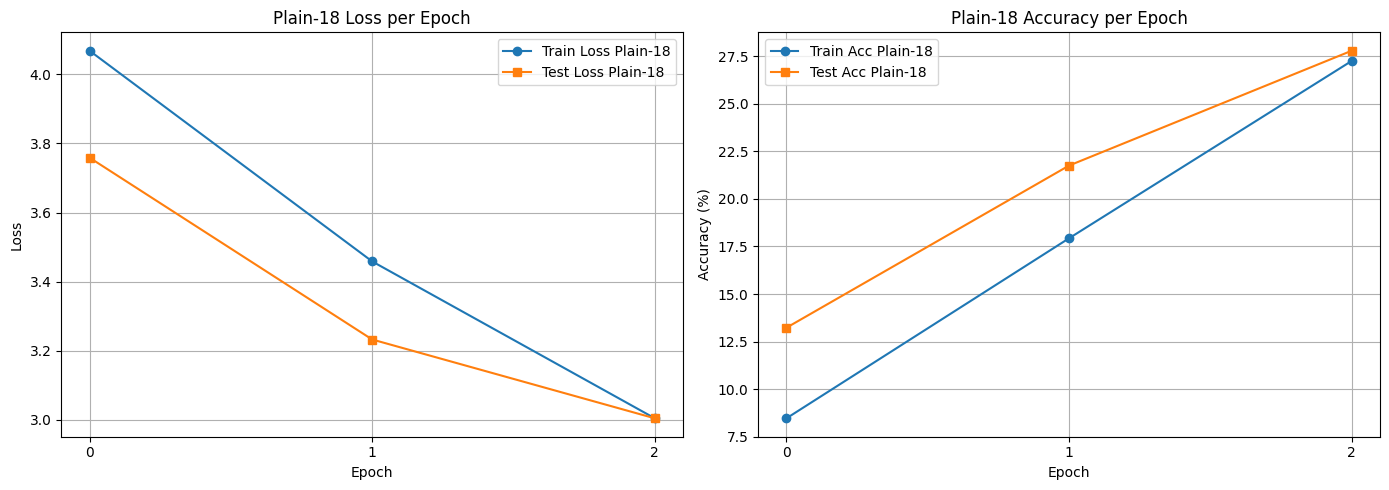

In [6]:
# Training loop    -  what optimiser? What learing rate, batch size etc.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

model = Plain18(num_classes=101).to(device)
batch_size = 64

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Metrics lists
Train_loss_plain18 = []
Train_acc_plain18 = []
Test_loss_plain18 = []
Test_acc_plain18 = []
Epoch_time_plain18 = []

# Training loop
epochs = 3  # quick testing
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()

    # Training
    model.train()
    running_loss, running_correct, total = 0, 0, 0
    for images, labels in tqdm(train_loader64, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_correct / total
    Train_loss_plain18.append(epoch_train_loss)
    Train_acc_plain18.append(epoch_train_acc)

    # Evaluation
    model.eval()
    test_loss, correct, total_test = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader64:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total_test += labels.size(0)

    epoch_test_loss = test_loss / total_test
    epoch_test_acc = correct / total_test
    Test_loss_plain18.append(epoch_test_loss)
    Test_acc_plain18.append(epoch_test_acc)

    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    Epoch_time_plain18.append(epoch_time)

    print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc*100:.2f}% | "
          f"Test Loss={epoch_test_loss:.4f}, Test Acc={epoch_test_acc*100:.2f}% | Time={epoch_time:.2f}s")

total_end_time = time.time()
print(f"Total training time: {total_end_time - total_start_time:.2f}s")


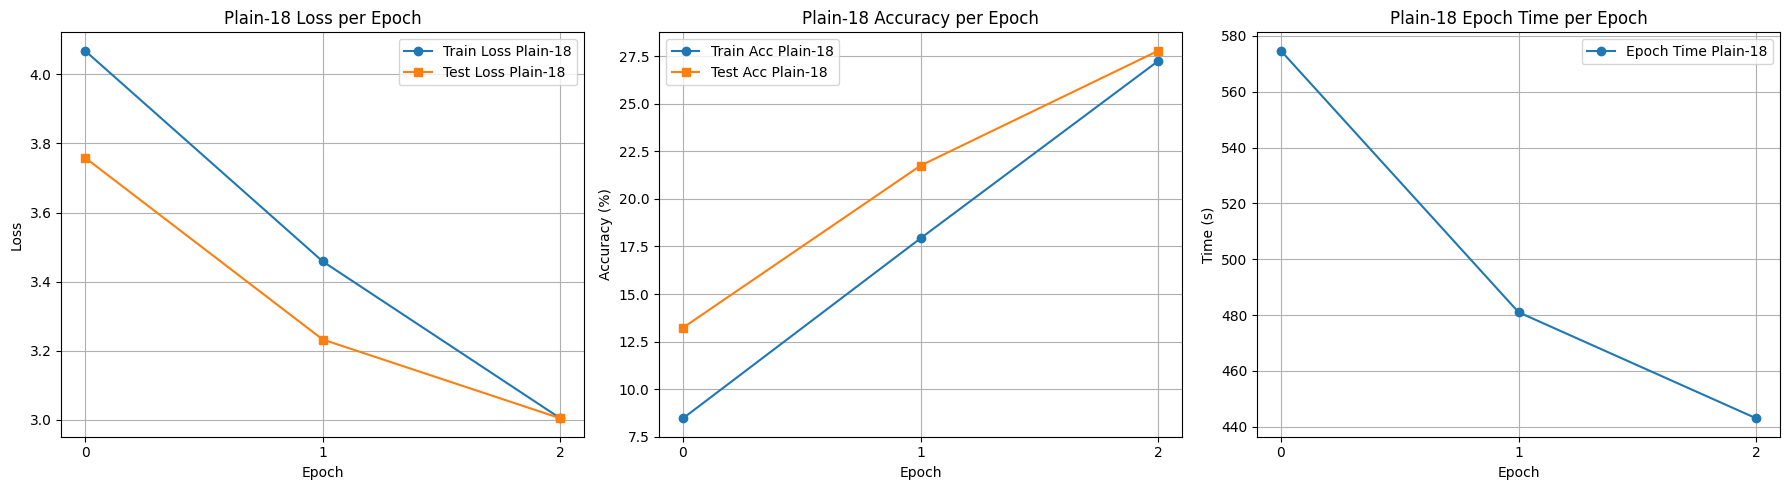

In [7]:
# Plot loss, accuracy and time per epoch
plt.figure(figsize=(18,5))


# Loss
plt.subplot(1,3,1)
plt.plot(Train_loss_plain18, marker='o', label="Train Loss Plain-18")
plt.plot(Test_loss_plain18, marker='s', label="Test Loss Plain-18")
plt.title("Plain-18 Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()


# Accuracy
plt.subplot(1,3,2)
plt.plot([a*100 for a in Train_acc_plain18], marker='o', label="Train Acc Plain-18")
plt.plot([a*100 for a in Test_acc_plain18], marker='s', label="Test Acc Plain-18")
plt.title("Plain-18 Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()


# Epoch Time
plt.subplot(1,3,3)
plt.plot(Epoch_time_plain18, marker='o', label="Epoch Time Plain-18")
plt.title("Plain-18 Epoch Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Some degradation might happen as we increase the number of layers. It happens because gradients vanish or explode as they backpropagate through many layers, making it hard to train very deep networks.Explore in more datail. this is why we introduce resnet, etc...


## Residual 18-layer CNN (ResNet-18)
With residual connections (classic ResNet)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Residual Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet18 - residual
class ResNet18(nn.Module):
    def __init__(self, num_classes=101):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_planes, planes, stride))
        self.in_planes = planes * BasicBlock.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.fc(out)
        return out

# Initialize model
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet18_model = ResNet18(num_classes=101).to(device)

# Training loop variables
batch_size = 64
epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=1e-3)

Train_loss_res18 = []
Train_acc_res18 = []
Test_loss_res18 = []
Test_acc_res18 = []
Epoch_time_res18 = []

# Training loop
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()

    # Training
    resnet18_model.train()
    running_loss, running_correct, total = 0,0,0
    for images, labels in tqdm(train_loader64, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_correct / total
    Train_loss_res18.append(epoch_train_loss)
    Train_acc_res18.append(epoch_train_acc)

    # Evaluation
    resnet18_model.eval()
    test_loss, correct, total_test = 0,0,0
    with torch.no_grad():
        for images, labels in test_loader64:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total_test += labels.size(0)

    epoch_test_loss = test_loss / total_test
    epoch_test_acc = correct / total_test
    Test_loss_res18.append(epoch_test_loss)
    Test_acc_res18.append(epoch_test_acc)

    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    Epoch_time_res18.append(epoch_time)

    print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc*100:.2f}% | "
          f"Test Loss={epoch_test_loss:.4f}, Test Acc={epoch_test_acc*100:.2f}% | Time={epoch_time:.2f}s")

total_end_time = time.time()
print(f"Total training time: {total_end_time - total_start_time:.2f}s")


ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, mo

Epoch 1/3: 100%|██████████| 1184/1184 [07:31<00:00,  2.62it/s]


Epoch 1: Train Loss=4.1031, Train Acc=7.95% | Test Loss=3.6563, Test Acc=13.94% | Time=554.96s


Epoch 2/3: 100%|██████████| 1184/1184 [07:31<00:00,  2.62it/s]


Epoch 2: Train Loss=3.4606, Train Acc=18.07% | Test Loss=3.1361, Test Acc=24.04% | Time=557.00s


Epoch 3/3: 100%|██████████| 1184/1184 [07:36<00:00,  2.60it/s]


Epoch 3: Train Loss=2.9449, Train Acc=28.29% | Test Loss=2.6708, Test Acc=33.67% | Time=560.98s
Total training time: 1672.95s


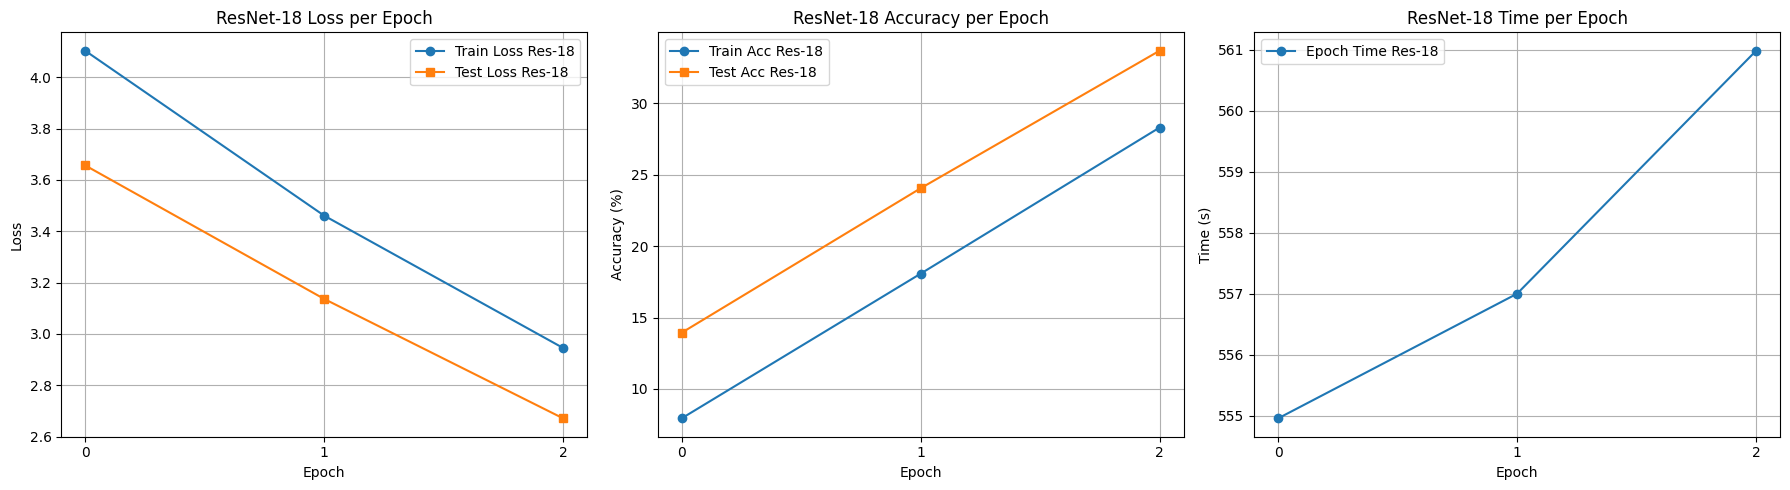

In [10]:
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(Train_loss_res18, marker='o', label="Train Loss Res-18")
plt.plot(Test_loss_res18, marker='s', label="Test Loss Res-18")
plt.title("ResNet-18 Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1,3,2)
plt.plot([a*100 for a in Train_acc_res18], marker='o', label="Train Acc Res-18")
plt.plot([a*100 for a in Test_acc_res18], marker='s', label="Test Acc Res-18")
plt.title("ResNet-18 Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()


# Epoch Time
plt.subplot(1,3,3)
plt.plot(Epoch_time_res18, marker='o', label="Epoch Time Res-18")
plt.title("ResNet-18 Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Pretrained ResNet-18

Load ResNet-18 pretrained on ImageNet. Fine-tune on your dataset

Load the ResNet-18 model pretrained on ImageNet.

Replace the final fully-connected layer to match your dataset's number of classes.

Optionally, freeze some early layers if you want to fine-tune only higher layers.

Train using your dataset.

In [11]:
import torch
import torch.nn as nn
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 101  # Food-101

# Load pretrained ResNet-18
pretrained_model = models.resnet18(pretrained=True)

# Replace final layer
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

# Move to device
pretrained_model = pretrained_model.to(device)

# (Optional) Freeze early layers if desired
# for name, param in pretrained_model.named_parameters():
#     if "layer4" not in name and "fc" not in name:
#         param.requires_grad = False

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=1e-4)



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 3
batch_size = 64

# Load pretrained ResNet-18
pretrained_resnet18 = models.resnet18(pretrained=True)
pretrained_resnet18.fc = nn.Linear(pretrained_resnet18.fc.in_features, num_classes)
pretrained_resnet18 = pretrained_resnet18.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet18.parameters(), lr=1e-4)  # lower LR for pretrained

# Metrics lists
Train_loss_resnet18 = []
Train_acc_resnet18 = []
Test_loss_resnet18 = []
Test_acc_resnet18 = []
Epoch_time_resnet18 = []

# Training loop
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()

    # Training
    pretrained_resnet18.train()
    running_loss, running_correct, total = 0, 0, 0
    for images, labels in tqdm(train_loader64, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = pretrained_resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_correct / total
    Train_loss_resnet18.append(epoch_train_loss)
    Train_acc_resnet18.append(epoch_train_acc)

    # Evaluation
    pretrained_resnet18.eval()
    test_loss, correct, total_test = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader64:
            images, labels = images.to(device), labels.to(device)
            outputs = pretrained_resnet18(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total_test += labels.size(0)

    epoch_test_loss = test_loss / total_test
    epoch_test_acc = correct / total_test
    Test_loss_resnet18.append(epoch_test_loss)
    Test_acc_resnet18.append(epoch_test_acc)

    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    Epoch_time_resnet18.append(epoch_time)

    print(f"Epoch {epoch+1}: Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc*100:.2f}% | "
          f"Test Loss={epoch_test_loss:.4f}, Test Acc={epoch_test_acc*100:.2f}% | Time={epoch_time:.2f}s")

total_end_time = time.time()
print(f"Total training time: {total_end_time - total_start_time:.2f}s")




Epoch 1/3: 100%|██████████| 1184/1184 [04:44<00:00,  4.16it/s]


Epoch 1: Train Loss=3.0826, Train Acc=28.01% | Test Loss=2.2611, Test Acc=43.00% | Time=365.22s


Epoch 2/3:  84%|████████▍ | 994/1184 [03:57<00:50,  3.79it/s]

In [ ]:
# Plotting Loss, Accuracy, Time
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(Train_loss_resnet18, marker='o', label="Train Loss ResNet-18")
plt.plot(Test_loss_resnet18, marker='s', label="Test Loss ResNet-18")
plt.title("ResNet-18 Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1,3,2)
plt.plot([a*100 for a in Train_acc_resnet18], marker='o', label="Train Acc ResNet-18")
plt.plot([a*100 for a in Test_acc_resnet18], marker='s', label="Test Acc ResNet-18")
plt.title("ResNet-18 Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()

# Epoch Time
plt.subplot(1,3,3)
plt.plot(Epoch_time_resnet18, marker='o', color='purple', label="Epoch Time (s)")
plt.title("ResNet-18 Epoch Time")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Comparison of differnt models

In [1]:
plt.figure(figsize=(18,5))


# Loss
plt.subplot(1,3,1)
plt.plot(Train_loss_plain18, marker='o', label="Train Loss Plain-18")
plt.plot(Test_loss_plain18, marker='s', label="Test Loss Plain-18")
plt.plot(Train_loss_res18, marker='^', label="Train Loss Residual-18")
plt.plot(Test_loss_res18, marker='v', label="Test Loss Residual-18")
plt.plot(Train_loss_resnet18, marker='D', label="Train Loss Pretrained-18")
plt.plot(Test_loss_resnet18, marker='X', label="Test Loss Pretrained-18")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend(fontsize=8)

# Accuracy
plt.subplot(1,3,2)
plt.plot([a*100 for a in Train_acc_plain18], marker='o', label="Train Acc Plain-18")
plt.plot([a*100 for a in Test_acc_plain18], marker='s', label="Test Acc Plain-18")
plt.plot([a*100 for a in Train_acc_res18], marker='^', label="Train Acc Residual-18")
plt.plot([a*100 for a in Test_acc_res18], marker='v', label="Test Acc Residual-18")
plt.plot([a*100 for a in Train_acc_resnet18], marker='D', label="Train Acc Pretrained-18")
plt.plot([a*100 for a in Test_acc_resnet18], marker='X', label="Test Acc Pretrained-18")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend(fontsize=8)

# Epoch Time
plt.subplot(1,3,3)
plt.plot(Epoch_time_plain18, marker='o', label="Plain-18")
plt.plot(Epoch_time_res18, marker='^', label="Residual-18")
plt.plot(Epoch_time_resnet18, marker='D', label="Pretrained-18")
plt.title("Epoch Time")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.xticks(range(epochs))
plt.grid(True)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined